# Cleaning the sampled dataset

For introduction and sampling of the dataset visit [this](nyc-collisions-data-sampling.ipynb) page.  

Imports and constants:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from tqdm import tqdm
import re

%matplotlib inline

data_path = "data/nyc_sample.csv"
geocoded_path = "data/nyc_geocoded.csv"
clean_data_path = "data/nyc_clean.csv"

The dataset is in a CSV file called nyc_sample.csv. Let's read the data into a pandas dataframe and inspect the first few rows of the data:

In [2]:
nyc_data = pd.read_csv(data_path)
pd.options.display.max_columns = 30 #to see all the columns
nyc_data.head(5)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,08/19/2018,0:40,NaN,NaN,40.622414,-73.896484,"(40.622414, -73.896484)",BELT PARKWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3963695,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,03/08/2018,13:00,QUEENS,11432.0,40.720165,-73.799020,"(40.720165, -73.79902)",168 STREET,GOETHALS AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3859433,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
2,11/11/2018,15:40,BRONX,10465.0,40.827282,-73.830170,"(40.827282, -73.83017)",HUNTINGTON AVENUE,LAFAYETTE AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4028471,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,11/16/2018,22:00,NaN,NaN,40.699936,-73.911810,"(40.699936, -73.91181)",WYCKOFF AVENUE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4028778,Dump,Sedan,NaN,NaN,NaN
4,01/03/2018,13:05,BRONX,10458.0,40.855690,-73.881035,"(40.85569, -73.881035)",NaN,NaN,2475 SOUTHERN BOULEVARD,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,3821653,PASSENGER VEHICLE,Van,NaN,NaN,NaN


## Cleaning column names

Before cleaning the data, let's check the column names and rename some of them, making them uniform.

In [3]:
nyc_data.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

When cleaning column names, let's use list comprehension to chain the vectorised operations on strings and clean all of them at once.

In [4]:
nyc_data.columns = [col
                    .lower()
                    .replace(" ", "_")
                    .replace("number_of_", "")
                    .replace("_name", "")
                    .replace("_code", "")
                    .replace("contributing_factor", "cause")
                    .replace("persons", "total")
                    for col in nyc_data.columns]

In [5]:
nyc_data.columns

Index(['date', 'time', 'borough', 'zip', 'latitude', 'longitude', 'location',
       'on_street', 'cross_street', 'off_street', 'total_injured',
       'total_killed', 'pedestrians_injured', 'pedestrians_killed',
       'cyclist_injured', 'cyclist_killed', 'motorist_injured',
       'motorist_killed', 'cause_vehicle_1', 'cause_vehicle_2',
       'cause_vehicle_3', 'cause_vehicle_4', 'cause_vehicle_5', 'unique_key',
       'vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3', 'vehicle_type_4',
       'vehicle_type_5'],
      dtype='object')

Our column names look much better, but let's change their order and simplify some of them. 

In [6]:
fixed_columns = ['unique_key', 'date', 'time', 'borough', 'zip', 'latitude', 'longitude', 
                    'location', 'on_street', 'cross_street', 'off_street', 
                    'pedestrians_injured', 'cyclist_injured', 'motorist_injured', 'total_injured', 
                    'pedestrians_killed', 'cyclist_killed', 'motorist_killed', 'total_killed', 
                    'vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3', 'vehicle_type_4', 
                    'vehicle_type_5', 'cause_vehicle_1', 'cause_vehicle_2','cause_vehicle_3', 
                    'cause_vehicle_4', 'cause_vehicle_5']
nyc_data = nyc_data[fixed_columns]

## Understanding missing values

From the sampling process we know, that there are lots of potentially missing values. To have a good overview of what's missing, let's create dataframe object neatly showing percentages of the values missing.

In [7]:
null_counts = nyc_data.isnull().sum()
null_counts_pct = null_counts / nyc_data.shape[0] * 100
null_dataframe = pd.DataFrame({"values_null": null_counts, "percentage_null": null_counts_pct})
print(null_dataframe)

                     values_null  percentage_null
unique_key                     0         0.000000
date                           0         0.000000
time                           0         0.000000
borough                    16507        35.653038
zip                        16515        35.670317
latitude                    2995         6.468822
longitude                   2995         6.468822
location                    2995         6.468822
on_street                  11098        23.970280
cross_street               23303        50.331541
off_street                 35338        76.325623
pedestrians_injured            0         0.000000
cyclist_injured                0         0.000000
motorist_injured               0         0.000000
total_injured                  1         0.002160
pedestrians_killed             0         0.000000
cyclist_killed                 0         0.000000
motorist_killed                0         0.000000
total_killed                   3         0.006480


Around 30% of the columns have no missing values. Since none of the `killed` and `injured` columns have missing values except for `total` columns, we can easily fill those values by calculating the sum.

In [8]:
killed_columns = [col for col in nyc_data 
                  if "killed" in col and "total" not in col] #retrieving columns containing 'killed' but not 'total'
killed_df = nyc_data[killed_columns].copy() #making a copy of the dataset with columns we want to sum
nyc_data["total_killed"] = killed_df.sum(axis=1)

injured_columns = [col for col in nyc_data 
                   if "injured" in col and "total" not in col]
injured_df = nyc_data[injured_columns].copy()
nyc_data["total_injured"] = injured_df.sum(axis=1)

Let's check whether there are any inconsistencies within those columns, such as values in total which are different than the sum.

In [9]:
injured_mask = (nyc_data["pedestrians_injured"] + nyc_data["cyclist_injured"]
                + nyc_data["motorist_injured"]) != nyc_data["total_injured"]
killed_mask = (nyc_data["pedestrians_killed"] + nyc_data["cyclist_killed"]
                + nyc_data["motorist_killed"]) != nyc_data["total_killed"] 

nyc_data[killed_mask].size, nyc_data[injured_mask].size

(0, 0)

In both cases we can see the dataframes being empty, which means there aren't any inconsistencies in the data.

Let's get a better understanding of the rest of missing data by creating a heatmap of all the values in our dataset.

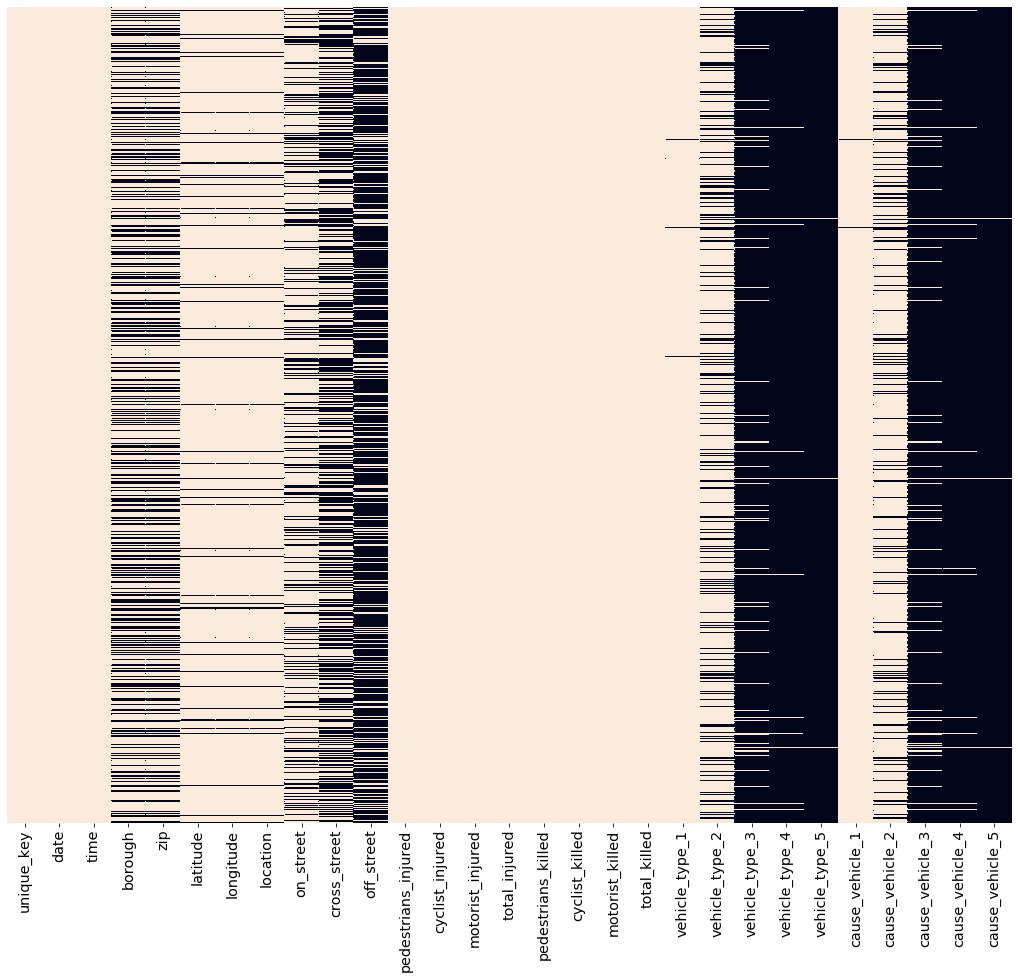

In [10]:
plt.figure(figsize=(18,15))
null_data = nyc_data.isnull() #boolean dataframe based on whether values are null
sns.heatmap(~null_data, cbar=False, yticklabels=False)#heatmap of the boolean dataframe, using ~ for inverted colours
plt.xticks(rotation=90, size='x-large')
plt.show()

Light tan colour represents values that are present, while black represents missing data. We can draw some conclusions by looking at the plot: 
1. Columns regarding type of vehicle or cause of the accident have most missing values, but it's nothing to worry about, since it's easily atributted to the number of cars involved in the accident (rarely more than two cars at a time are involved accident). Filling those values will be relatively easy.
2. Columns regarding streets are alternately filled and null, e.g. when on_street has no value, off_street or cross_street has a value and vice versa. Not all the accidents happened on the intersections, so filling some of cross_street values could be wrong. Because we don't need these columns to be overly specific, we could reduce them to one column, filling nulls with values from two others.
3. Latitude and longitude columns can be dropped, because location is a combination of both.
4. Borough values could be potentially filled using external API based off of coordinates. Zip can be filled using the same technique.
5. We will deal with missing location values later on in the process.

## Dealing with the rest of missing values

Let's delete columns we won't need for our analysis: latitude and longitude.

In [11]:
nyc_data.drop(["latitude", "longitude"], axis=1, inplace=True)
#check top with inplace=True
nyc_data.head(2)

,unique_key,date,time,borough,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3963695,08/19/2018,0:40,NaN,NaN,"(40.622414, -73.896484)",BELT PARKWAY,NaN,NaN,0,0,0,0,0,0,0,0,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN
1,3859433,03/08/2018,13:00,QUEENS,11432.0,"(40.720165, -73.79902)",168 STREET,GOETHALS AVENUE,NaN,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,Unspecified,Unspecified,NaN,NaN,NaN


In [12]:
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46299 entries, 0 to 46298
Data columns (total 27 columns):
unique_key             46299 non-null int64
date                   46299 non-null object
time                   46299 non-null object
borough                29792 non-null object
zip                    29784 non-null float64
location               43304 non-null object
on_street              35201 non-null object
cross_street           22996 non-null object
off_street             10961 non-null object
pedestrians_injured    46299 non-null int64
cyclist_injured        46299 non-null int64
motorist_injured       46299 non-null int64
total_injured          46299 non-null int64
pedestrians_killed     46299 non-null int64
cyclist_killed         46299 non-null int64
motorist_killed        46299 non-null int64
total_killed           46299 non-null int64
vehicle_type_1         46023 non-null object
vehicle_type_2         36506 non-null object
vehicle_type_3         2777 non-null object


In [13]:
# streets = nyc_data.iloc[:, 6:9]
# vehicle_types = nyc_data.iloc[:, 17:22]
# vehicle_causes = nyc_data.iloc[:, 22:]

First, let's handle the null values for vehicle_type and cause_vehicle. Because we don't want to loose or mistakenly change any data regarding number of vehicles involved in an accident as well as types of those vehicles, the best way of dealing with nulls is to:
- set the vehicle to Unspecified for values where the vehicle is null and the cause is non-null.
- set the vehicle to Unspecified for values where the cause is null and the vehicle is not-null.

For the rest of the null values, we'll set the value to Not Involved. Let's create boolean masks for these columns and fill missing values.

In [14]:
nyc_data.iloc[[7,1474,1997,3863],17:]

,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
7,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
1474,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,Driver Inattention/Distraction,Following Too Closely,Unspecified,Unspecified,Unspecified
1997,Sedan,Sedan,Sedan,Sedan,NaN,Alcohol Involvement,Unspecified,Unspecified,Unspecified,Unspecified
3863,Pick-up Truck,Sedan,Sedan,Sedan,NaN,Unsafe Speed,Lane Marking Improper/Inadequate,Lane Marking Improper/Inadequate,Obstruction/Debris,Obstruction/Debris


We can clearly see, that last three rows had 5 vehicles involved, but in each case, 5th vehicle type is a null value. Let's set all of those to Unspecified and the rest of nulls to Not Involved.

In [15]:
for value in range(1,6):
    type_col = 'vehicle_type_{}'.format(value)
    cause_col = 'cause_vehicle_{}'.format(value)
    
    type_missing_boolmask = nyc_data[type_col].isnull() & nyc_data[cause_col].notnull()
    cause_missing_boolmask = nyc_data[type_col].notnull() & nyc_data[cause_col].isnull()
    nyc_data[type_col] = nyc_data[type_col].mask(type_missing_boolmask, "Unspecified")
    nyc_data[cause_col] = nyc_data[cause_col].mask(cause_missing_boolmask, "Unspecified")

    type_null_boolmask = nyc_data[type_col].isnull()
    cause_null_boolmask = nyc_data[cause_col].isnull()
    nyc_data[type_col] = nyc_data[type_col].mask(type_null_boolmask, "Not involved")
    nyc_data[cause_col] = nyc_data[cause_col].mask(cause_null_boolmask, "Not involved")

Let's check those columns again to see if the values have changed.

In [16]:
nyc_data.iloc[[7, 1474,1997,3863],17:]

,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
7,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Following Too Closely,Unspecified,Not involved,Not involved,Not involved
1474,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Unspecified,Driver Inattention/Distraction,Following Too Closely,Unspecified,Unspecified,Unspecified
1997,Sedan,Sedan,Sedan,Sedan,Unspecified,Alcohol Involvement,Unspecified,Unspecified,Unspecified,Unspecified
3863,Pick-up Truck,Sedan,Sedan,Sedan,Unspecified,Unsafe Speed,Lane Marking Improper/Inadequate,Lane Marking Improper/Inadequate,Obstruction/Debris,Obstruction/Debris


Time to fill the boroughs and zip codes based on coordinates. To accomplish this, we will use geopy library with Nominatim as a geocoding service, since it's free with some minor [restrictions](https://operations.osmfoundation.org/policies/nominatim/).

In [17]:
nyc_data["borough"].value_counts(dropna=False)

NaN              16507
BROOKLYN          9548
QUEENS            8230
MANHATTAN         6236
BRONX             4548
STATEN ISLAND     1230
Name: borough, dtype: int64

Let's simplyfy the location column to make the process of geolocation a little easier.

In [18]:
nyc_data["location"] = (nyc_data["location"]
                        .str.replace("(", "")
                        .str.replace(")", ""))

Time to identify rows without boroughs (these rows don't have zip codes either), create a copy and save it to another dataframe, so we won't mess up our original dataframe. 

In [19]:
borough_null_boolmask = nyc_data["borough"].isnull() & nyc_data["location"].notnull()
null_boroughs_df = nyc_data.iloc[:, :9][borough_null_boolmask].copy()

Since we don't need all the columns, let's create a smaller copy of our dataframe. We'll use it to assign back the results from our geocoding service.

In [20]:
null_boroughs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14420 entries, 0 to 46297
Data columns (total 9 columns):
unique_key      14420 non-null int64
date            14420 non-null object
time            14420 non-null object
borough         0 non-null object
zip             0 non-null float64
location        14420 non-null object
on_street       13912 non-null object
cross_street    2467 non-null object
off_street      433 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 1.1+ MB


In [21]:
null_boroughs_df.head(5)

,unique_key,date,time,borough,zip,location,on_street,cross_street,off_street
0,3963695,08/19/2018,0:40,NaN,NaN,"40.622414, -73.896484",BELT PARKWAY,NaN,NaN
3,4028778,11/16/2018,22:00,NaN,NaN,"40.699936, -73.91181",WYCKOFF AVENUE,NaN,NaN
5,3846436,02/14/2018,8:27,NaN,NaN,"40.879486, -73.87124",WEBSTER AVENUE,NaN,NaN
9,3926225,06/21/2018,17:26,NaN,NaN,"40.73448, -73.92243",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN
14,3957240,08/05/2018,23:00,NaN,NaN,"40.685356, -73.93852",PUTNAM AVENUE,NaN,NaN


Now, let's use geopy library. Our geolocation service requires us to provide a custom user_agent for the connection. Furthermore, since it's free, we can go as fast as one request per second. We'll use tqdm library to keep an eye on the progress. Code below commented out to prevent running it by accident by viewer (it takes a reaaaaally long time to finish).

In [22]:
# tqdm.pandas()
# geolocator = Nominatim(user_agent="nyc-collisions")
# geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
# null_boroughs_df["geocoded"] = null_boroughs_df.iloc[:,4].progress_apply(geocode)

Let's create some additional columns in our dataframe.

In [23]:
# null_boroughs_df.insert(9, "zipcodes", np.nan)

Let's delete rows with null values in 'geocoded' column, we won't be able to fill them in anyways, and it's only a 1% data loss. 

In [24]:
# null_boroughs_df = null_boroughs_df[null_boroughs_df.geocoded.notnull()]

Let's extract zipcodes and boroughs.

In [25]:
# # zipcodes
# pattern = r'(?<=, )(\d{5})(?=,)'

# for index in range(len(null_boroughs_df.iloc[:,:])):
#     ex_string_df = null_boroughs_df.iloc[index, 9]
#     if (re.search(pattern, str(ex_string_df))):
#         regex_found = re.search(pattern, str(ex_string_df), re.IGNORECASE).group(1)
#         null_boroughs_df.iloc[index, 10] = regex_found
#     else:
#         null_boroughs_df.iloc[index, 10] = "00000"

In [26]:
# # boroughs
# pattern = r'(?<=, )(Bronx)(?=,)' #currently can't figure out how to do it in more elegant manner, just change the borough You're looking to fill.

# for index in range(len(null_boroughs_df.iloc[:,:])):
#     ex_string_df = null_boroughs_df.iloc[index, 9]
#     if (re.search(pattern, str(ex_string_df))):
#         regex_found = re.search(pattern, str(ex_string_df), re.IGNORECASE).group(1)
#         null_boroughs_df.iloc[index, 3] = regex_found
#     else:
#         continue

Let's delete rows with nulls in borough column.

In [27]:
# null_boroughs_df = null_boroughs_df[null_boroughs_df.borough.notnull()]

We won't fill in the missing street names the same way, because the geolocation service tends to provide location or landmark name (if there is one nearby) instead of exact street address, which we're interested in. 

Once that's done, let's save the data into a new csv file, just in case something goes wrong or someone needs that file.

In [28]:
# geocoded_export = null_boroughs_df.to_csv(geocoded_path, index=None, header=True)

### Combining the datasets and filling in values

Time to read in our dataset with geocoded values and fill in null values in `nyc_data`.

In [29]:
geocoded_dataset = pd.read_csv(geocoded_path)

In [30]:
geocoded_dataset.columns

Index(['unique_key', 'date', 'time', 'borough', 'location', 'on_street',
       'cross_street', 'off_street', 'geocoded', 'zipcodes'],
      dtype='object')

In [31]:
geocoded_dataset["borough"].value_counts()

Queens           4495
BK               3593
Manhattan        2784
The Bronx        2310
Staten Island    1181
Name: borough, dtype: int64

In [32]:
geocoded_dataset[geocoded_dataset["unique_key"] == 3846436]

,unique_key,date,time,borough,location,on_street,cross_street,off_street,geocoded,zipcodes
2,3846436,02/14/2018,8:27,The Bronx,"40.879486, -73.87124",WEBSTER AVENUE,NaN,NaN,"3510, Webster Avenue, Woodlawn, The Bronx, Bro...",10467


In [33]:
nyc_data[nyc_data["unique_key"] == 3846436]

,unique_key,date,time,borough,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
5,3846436,02/14/2018,8:27,NaN,NaN,"40.879486, -73.87124",WEBSTER AVENUE,NaN,NaN,0,0,0,0,0,0,0,0,PICK-UP TRUCK,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Unspecified,Unspecified,Not involved,Not involved,Not involved


In [34]:
geocoded_slice_df = geocoded_dataset[["unique_key", "borough", "zipcodes"]]
geocoded_slice_df.head(5)

,unique_key,borough,zipcodes
0,3963695,BK,11236
1,4028778,BK,11237
2,3846436,The Bronx,10467
3,3926225,Queens,11104
4,3957240,BK,11221


Let's merge the two datasets using pd.merge. We could actually just fill in two columns in the original dataset without merging them, but we'll do it to make double-checking things later easier.

In [35]:
nyc_filled_data = nyc_data.merge(right=geocoded_slice_df, on="unique_key", how="left")

Time to fill in the missing data from our merged columns.

In [36]:
nyc_filled_data["borough_x"].fillna(nyc_filled_data["borough_y"], axis=0, inplace=True)
nyc_filled_data["zip"].fillna(nyc_filled_data["zipcodes"], axis=0, inplace=True)

Let's check whether it worked:

In [37]:
nyc_filled_data.iloc[:, [0,3,4,27,28]].head(10)

,unique_key,borough_x,zip,borough_y,zipcodes
0,3963695,BK,11236.0,BK,11236.0
1,3859433,QUEENS,11432.0,NaN,NaN
2,4028471,BRONX,10465.0,NaN,NaN
3,4028778,BK,11237.0,BK,11237.0
4,3821653,BRONX,10458.0,NaN,NaN
5,3846436,The Bronx,10467.0,The Bronx,10467.0
6,3844259,MANHATTAN,10002.0,NaN,NaN
7,3873861,BRONX,10466.0,NaN,NaN
8,3952239,BROOKLYN,11217.0,NaN,NaN
9,3926225,Queens,11104.0,Queens,11104.0


In [38]:
nyc_filled_data.drop(["borough_y", "zipcodes"], axis=1, inplace=True)

In [39]:
nyc_filled_data.head(10)

,unique_key,date,time,borough_x,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3963695,08/19/2018,0:40,BK,11236.0,"40.622414, -73.896484",BELT PARKWAY,NaN,NaN,0,0,0,0,0,0,0,0,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Unspecified,Not involved,Not involved,Not involved
1,3859433,03/08/2018,13:00,QUEENS,11432.0,"40.720165, -73.79902",168 STREET,GOETHALS AVENUE,NaN,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Unspecified,Unspecified,Not involved,Not involved,Not involved
2,4028471,11/11/2018,15:40,BRONX,10465.0,"40.827282, -73.83017",HUNTINGTON AVENUE,LAFAYETTE AVENUE,NaN,0,0,0,0,0,0,0,0,Sedan,Station Wagon/Sport Utility Vehicle,Not involved,Not involved,Not involved,Backing Unsafely,Unspecified,Not involved,Not involved,Not involved
3,4028778,11/16/2018,22:00,BK,11237.0,"40.699936, -73.91181",WYCKOFF AVENUE,NaN,NaN,0,0,0,0,0,0,0,0,Dump,Sedan,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Unspecified,Not involved,Not involved,Not involved
4,3821653,01/03/2018,13:05,BRONX,10458.0,"40.85569, -73.881035",NaN,NaN,2475 SOUTHERN BOULEVARD,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,Van,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Driver Inattention/Distraction,Not involved,Not involved,Not involved
5,3846436,02/14/2018,8:27,The Bronx,10467.0,"40.879486, -73.87124",WEBSTER AVENUE,NaN,NaN,0,0,0,0,0,0,0,0,PICK-UP TRUCK,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Unspecified,Unspecified,Not involved,Not involved,Not involved
6,3844259,02/10/2018,15:40,MANHATTAN,10002.0,"40.72145, -73.98579",NaN,NaN,178 NORFOLK STREET,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Not involved,Unspecified,Not involved,Not involved,Not involved,Not involved
7,3873861,03/22/2018,18:57,BRONX,10466.0,"40.87987, -73.842026",BOSTON ROAD,EAST 224 STREET,NaN,0,0,0,0,0,0,0,0,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Following Too Closely,Unspecified,Not involved,Not involved,Not involved
8,3952239,07/31/2018,9:35,BROOKLYN,11217.0,"40.68087, -73.97515",FLATBUSH AVENUE,BERGEN STREET,NaN,0,0,0,0,0,0,0,0,Bus,Sedan,Not involved,Not involved,Not involved,Passing or Lane Usage Improper,Unspecified,Not involved,Not involved,Not involved
9,3926225,06/21/2018,17:26,Queens,11104.0,"40.73448, -73.92243",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,0,0,0,0,0,0,0,0,Sedan,Sedan,Unspecified,Not involved,Not involved,Driver Inattention/Distraction,Driver Inattention/Distraction,Unspecified,Not involved,Not involved


Let's see how many values in borough column are still null, and what percentage of the whole dataset it is:

In [40]:
(len(nyc_filled_data[nyc_filled_data["borough_x"].isnull()]))/(len(nyc_filled_data["borough_x"]))*100

4.630769563057517

And now same for zip column:

In [41]:
(len(nyc_filled_data[nyc_filled_data["zip"].isnull()]))/(len(nyc_filled_data["zip"]))*100

4.553014103976328

Dropping those rows we'll loose only 4.6% data in our dataset which is something we will have to deal with for now, as there is no other way to fill in those values.

In [42]:
nyc_filled_data.dropna(subset=["borough_x", "zip"], inplace=True)

We know from the process of collecting the data using geolocation serivce, that some location values are null, because we were unable to gather any data for them. Surely, some of those columns are gone now, but let's check whether there are any left. And what the values in them look like.

In [43]:
(len(nyc_filled_data[nyc_filled_data["location"].isnull()]))/(len(nyc_filled_data["location"]))*100

2.054499739506648

In [44]:
nyc_filled_data[nyc_filled_data["location"].isnull()].head(5)

,unique_key,date,time,borough_x,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
24,3942105,07/16/2018,12:24,QUEENS,11368.0,NaN,126 STREET,NORTHERN BOULEVARD,NaN,0,0,0,0,0,0,0,0,Sedan,Dump,Not involved,Not involved,Not involved,Unspecified,Unspecified,Not involved,Not involved,Not involved
60,3956316,08/03/2018,14:10,MANHATTAN,10019.0,NaN,9 AVENUE,WEST 59 STREET,NaN,0,0,0,0,0,0,0,0,Taxi,Taxi,Not involved,Not involved,Not involved,Unsafe Lane Changing,Unspecified,Not involved,Not involved,Not involved
116,3943116,07/17/2018,14:50,MANHATTAN,10020.0,NaN,WEST 50 STREET,AVENUE OF THE AMERICAS,NaN,0,0,0,0,0,0,0,0,Garbage or Refuse,Taxi,Not involved,Not involved,Not involved,Passing Too Closely,Passing Too Closely,Not involved,Not involved,Not involved
141,3858282,03/06/2018,15:10,MANHATTAN,10002.0,NaN,EAST BROADWAY,PIKE STREET,NaN,0,0,0,0,0,0,0,0,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Unspecified,Not involved,Not involved,Not involved
170,3826656,01/11/2018,8:20,MANHATTAN,10019.0,NaN,COLUMBUS CIRCLE,CENTRAL PARK SOUTH,NaN,0,0,0,0,0,0,0,0,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,Not involved,Not involved,Not involved,Other Vehicular,Other Vehicular,Not involved,Not involved,Not involved


These rows are an additional 2% of all rows, but since all of them have values in both borough and zip columns, we will just fill those nulls with Unspecified.

In [45]:
nyc_filled_data["location"].mask(nyc_filled_data["location"].isnull(), "Unspecified", inplace=True)

### Dealing with missing street names

After checking out all the combinations of each column being null and others not null, we can conclude that reducing those columns to just one would mean we loose a lot of extra data.

The best solution would be to delete rows, where all three are null and fill the rest with "Unspecified", so that they aren't null anymore and because it will be interesting to see, whether any addresses come up more often than others. Ultimately, we can delete these columns later if they are really not needed.

In [46]:
null_streets_boolmask = ((nyc_filled_data["on_street"].isnull()) & (nyc_filled_data["cross_street"].isnull())
                              & (nyc_filled_data["off_street"].isnull()))
len(nyc_filled_data[null_streets_boolmask])

74

Only 74 rows have all of those columns null, let's delete them and fill the rest of the nulls.

In [47]:
not_null_streets_boolmask = ((nyc_filled_data["on_street"].notnull()) | (nyc_filled_data["cross_street"].notnull())
                             | (nyc_filled_data["off_street"].notnull()))
nyc_filled_data = nyc_filled_data[not_null_streets_boolmask]

In [48]:
nyc_filled_data["on_street"].mask(nyc_filled_data["on_street"].isnull(), "Unspecified", inplace=True)
nyc_filled_data["cross_street"].mask(nyc_filled_data["cross_street"].isnull(), "Unspecified", inplace=True)
nyc_filled_data["off_street"].mask(nyc_filled_data["off_street"].isnull(), "Unspecified", inplace=True)

In [49]:
nyc_filled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44073 entries, 0 to 46297
Data columns (total 27 columns):
unique_key             44073 non-null int64
date                   44073 non-null object
time                   44073 non-null object
borough_x              44073 non-null object
zip                    44073 non-null float64
location               44073 non-null object
on_street              44073 non-null object
cross_street           44073 non-null object
off_street             44073 non-null object
pedestrians_injured    44073 non-null int64
cyclist_injured        44073 non-null int64
motorist_injured       44073 non-null int64
total_injured          44073 non-null int64
pedestrians_killed     44073 non-null int64
cyclist_killed         44073 non-null int64
motorist_killed        44073 non-null int64
total_killed           44073 non-null int64
vehicle_type_1         44073 non-null object
vehicle_type_2         44073 non-null object
vehicle_type_3         44073 non-null object

In [50]:
streets_boolmask = ((nyc_filled_data["on_street"].isnull()) | (nyc_filled_data["cross_street"].isnull())
                             | (nyc_filled_data["off_street"].notnull()))
nyc_filled_data[streets_boolmask].head(10)

,unique_key,date,time,borough_x,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3963695,08/19/2018,0:40,BK,11236.0,"40.622414, -73.896484",BELT PARKWAY,Unspecified,Unspecified,0,0,0,0,0,0,0,0,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Unspecified,Not involved,Not involved,Not involved
1,3859433,03/08/2018,13:00,QUEENS,11432.0,"40.720165, -73.79902",168 STREET,GOETHALS AVENUE,Unspecified,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Unspecified,Unspecified,Not involved,Not involved,Not involved
2,4028471,11/11/2018,15:40,BRONX,10465.0,"40.827282, -73.83017",HUNTINGTON AVENUE,LAFAYETTE AVENUE,Unspecified,0,0,0,0,0,0,0,0,Sedan,Station Wagon/Sport Utility Vehicle,Not involved,Not involved,Not involved,Backing Unsafely,Unspecified,Not involved,Not involved,Not involved
3,4028778,11/16/2018,22:00,BK,11237.0,"40.699936, -73.91181",WYCKOFF AVENUE,Unspecified,Unspecified,0,0,0,0,0,0,0,0,Dump,Sedan,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Unspecified,Not involved,Not involved,Not involved
4,3821653,01/03/2018,13:05,BRONX,10458.0,"40.85569, -73.881035",Unspecified,Unspecified,2475 SOUTHERN BOULEVARD,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,Van,Not involved,Not involved,Not involved,Driver Inattention/Distraction,Driver Inattention/Distraction,Not involved,Not involved,Not involved
5,3846436,02/14/2018,8:27,The Bronx,10467.0,"40.879486, -73.87124",WEBSTER AVENUE,Unspecified,Unspecified,0,0,0,0,0,0,0,0,PICK-UP TRUCK,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Unspecified,Unspecified,Not involved,Not involved,Not involved
6,3844259,02/10/2018,15:40,MANHATTAN,10002.0,"40.72145, -73.98579",Unspecified,Unspecified,178 NORFOLK STREET,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Not involved,Unspecified,Not involved,Not involved,Not involved,Not involved
7,3873861,03/22/2018,18:57,BRONX,10466.0,"40.87987, -73.842026",BOSTON ROAD,EAST 224 STREET,Unspecified,0,0,0,0,0,0,0,0,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,Not involved,Not involved,Not involved,Following Too Closely,Unspecified,Not involved,Not involved,Not involved
8,3952239,07/31/2018,9:35,BROOKLYN,11217.0,"40.68087, -73.97515",FLATBUSH AVENUE,BERGEN STREET,Unspecified,0,0,0,0,0,0,0,0,Bus,Sedan,Not involved,Not involved,Not involved,Passing or Lane Usage Improper,Unspecified,Not involved,Not involved,Not involved
9,3926225,06/21/2018,17:26,Queens,11104.0,"40.73448, -73.92243",BROOKLYN QUEENS EXPRESSWAY,Unspecified,Unspecified,0,0,0,0,0,0,0,0,Sedan,Sedan,Unspecified,Not involved,Not involved,Driver Inattention/Distraction,Driver Inattention/Distraction,Unspecified,Not involved,Not involved


All null values are dealt with, time to clean the values in all of our columns.

## Cleaning up the rest of the values

To be consistent with our data, let's make sure all the entires are in uppercase

In [51]:
cols = ['borough_x', 'on_street', 'cross_street', 'off_street', 'vehicle_type_1', 
        'vehicle_type_2', 'vehicle_type_3','vehicle_type_4', 'vehicle_type_5',
        'cause_vehicle_1','cause_vehicle_2', 'cause_vehicle_3', 'cause_vehicle_4',
        'cause_vehicle_5']

for col in cols:
    nyc_filled_data[col] = nyc_filled_data[col].str.upper()

In [52]:
nyc_filled_data.head(7)

,unique_key,date,time,borough_x,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3963695,08/19/2018,0:40,BK,11236.0,"40.622414, -73.896484",BELT PARKWAY,UNSPECIFIED,UNSPECIFIED,0,0,0,0,0,0,0,0,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
1,3859433,03/08/2018,13:00,QUEENS,11432.0,"40.720165, -73.79902",168 STREET,GOETHALS AVENUE,UNSPECIFIED,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,PASSENGER VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,UNSPECIFIED,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
2,4028471,11/11/2018,15:40,BRONX,10465.0,"40.827282, -73.83017",HUNTINGTON AVENUE,LAFAYETTE AVENUE,UNSPECIFIED,0,0,0,0,0,0,0,0,SEDAN,STATION WAGON/SPORT UTILITY VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,BACKING UNSAFELY,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
3,4028778,11/16/2018,22:00,BK,11237.0,"40.699936, -73.91181",WYCKOFF AVENUE,UNSPECIFIED,UNSPECIFIED,0,0,0,0,0,0,0,0,DUMP,SEDAN,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
4,3821653,01/03/2018,13:05,BRONX,10458.0,"40.85569, -73.881035",UNSPECIFIED,UNSPECIFIED,2475 SOUTHERN BOULEVARD,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,VAN,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,DRIVER INATTENTION/DISTRACTION,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
5,3846436,02/14/2018,8:27,THE BRONX,10467.0,"40.879486, -73.87124",WEBSTER AVENUE,UNSPECIFIED,UNSPECIFIED,0,0,0,0,0,0,0,0,PICK-UP TRUCK,PASSENGER VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,UNSPECIFIED,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
6,3844259,02/10/2018,15:40,MANHATTAN,10002.0,"40.72145, -73.98579",UNSPECIFIED,UNSPECIFIED,178 NORFOLK STREET,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED


At this point, only `borough` and `vehicle_type_1` through `cause_vehicle_5` need any cleaning with the rest of the values being fine or previously cleaned.

In [53]:
nyc_filled_data["borough_x"].value_counts()

QUEENS           12718
BROOKLYN          9548
MANHATTAN         9018
BRONX             4548
BK                3593
STATEN ISLAND     2338
THE BRONX         2310
Name: borough_x, dtype: int64

In [54]:
nyc_filled_data["borough_x"] = (nyc_filled_data["borough_x"]
                                .str.replace("BK", "BROOKLYN")
                                .str.replace("THE BRONX", "BRONX"))

Time to check vehicle types and causes and reduce them to only a few that are of interest to us.

In [55]:
nyc_filled_data["vehicle_type_1"].value_counts().head(5)

SEDAN                                  13546
STATION WAGON/SPORT UTILITY VEHICLE    10416
PASSENGER VEHICLE                       6780
SPORT UTILITY / STATION WAGON           5348
TAXI                                    2227
Name: vehicle_type_1, dtype: int64

As we can see, there are about 150 types of vehicles reported. However, only a few of them are somewhat relevant to our analysis: bike (or bicycle), motorbike and any other type of vehicle. There are a lot of ambiguous values in these columns, but they are not crucial to our analysis. Furthermore, keeping it overly clean and trying to change some of the values could result in some potential data loss. For the sake of other people using this data for their own analysis, we will only simplify some of the most conspicuous values.

In [56]:
cols_vehicle_types = ['vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3',
                      'vehicle_type_4', 'vehicle_type_5']

for col in cols_vehicle_types:
    nyc_filled_data[col] = (nyc_filled_data[col]
                            .str.replace("STATION WAGON/SPORT UTILITY VEHICLE", "SUV/STATION WAGON")
                            .str.replace("SPORT UTILITY / STATION WAGON", "SUV/STATION WAGON")
                            .str.replace("BIKE", "BICYCLE")
                            .str.replace(" DIESEL", ""))

Now let's check out `cause` columns and decide on our approach.

In [57]:
nyc_filled_data["cause_vehicle_1"].value_counts().head(5)

DRIVER INATTENTION/DISTRACTION    10935
UNSPECIFIED                        9589
FOLLOWING TOO CLOSELY              4054
FAILURE TO YIELD RIGHT-OF-WAY      3107
BACKING UNSAFELY                   2191
Name: cause_vehicle_1, dtype: int64

As we can see, there is no need to further clean up `cause` columns as all of the values seem to be good enough for our analysis. Last but not least, let's rename the `borough_x` column to just `borough`.

In [58]:
nyc_filled_data.rename({"borough_x": "borough"}, axis=1, inplace=True)

Time to save our clean dataset.

In [59]:
nyc_filled_data.to_csv(clean_data_path, index=None, header=True)

## Conclusion

We have successfully cleaned our dataset along with filling in values from a geolocation service. During the process, we have lost only less than 1% of our data. Next part of the project - data analysis can be found [here](nyc-collisions-data-analysis.ipynb).